In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.polynomial.polynomial import Polynomial
from scipy.optimize import curve_fit

sns.set(style="whitegrid")

csv_path = "wandb_data/3 stat results/"

In [4]:
# [eqfd3r35](https://wandb.ai/s-ruff-tu-delft/NoisyNeuralNet-v7/sweeps/eqfd3r35)
df_con_noisy_reward   = pd.read_csv(csv_path + "Con NoisyNet 0 9 reward.csv")
df_con_noisy_regret   = pd.read_csv(csv_path + "Con NoisyNet 0 9 regret.csv")
df_con_noisy_expl     = pd.read_csv(csv_path + "Con NoisyNet 0 9 exploration_rate.csv")
df_nn_noisy_reward    = pd.read_csv(csv_path +  "NN NoisyNet 0 9 reward.csv")
df_nn_noisy_regret    = pd.read_csv(csv_path +  "NN NoisyNet 0 9 regret.csv")
df_nn_noisy_expl      = pd.read_csv(csv_path +  "NN NoisyNet 0 9 exploration_rate.csv")
df_con_regular_reward = pd.read_csv(csv_path + "Con regular 0 9 reward.csv")
df_con_regular_regret = pd.read_csv(csv_path + "Con regular 0 9 regret.csv")
df_con_regular_expl   = pd.read_csv(csv_path + "Con regular 0 9 exploration_rate.csv")
df_nn_regular_reward  = pd.read_csv(csv_path +  "NN regular 0 9 reward.csv")
df_nn_regular_regret  = pd.read_csv(csv_path +  "NN regular 0 9 regret.csv")
df_nn_regular_expl    = pd.read_csv(csv_path +  "NN regular 0 9 exploration_rate.csv")

def drop_min_max_columns(df):
    return df[[col for col in df.columns if not (col.endswith('__MIN') or col.endswith('__MAX'))]]

df_con_noisy_reward   = drop_min_max_columns(df_con_noisy_reward)
df_con_noisy_regret   = drop_min_max_columns(df_con_noisy_regret)
df_con_noisy_expl     = drop_min_max_columns(df_con_noisy_expl)
df_nn_noisy_reward    = drop_min_max_columns(df_nn_noisy_reward)
df_nn_noisy_regret    = drop_min_max_columns(df_nn_noisy_regret)
df_nn_noisy_expl      = drop_min_max_columns(df_nn_noisy_expl)
df_con_regular_reward = drop_min_max_columns(df_con_regular_reward)
df_con_regular_regret = drop_min_max_columns(df_con_regular_regret)
df_con_regular_expl   = drop_min_max_columns(df_con_regular_expl)
df_nn_regular_reward  = drop_min_max_columns(df_nn_regular_reward)
df_nn_regular_regret  = drop_min_max_columns(df_nn_regular_regret)
df_nn_regular_expl    = drop_min_max_columns(df_nn_regular_expl)

In [5]:
df_nn_noisy_expl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Step                                                        2000 non-null   int64  
 1   conbandit_combi1_0__9__2025-07-01_12-51 - exploration_rate  2000 non-null   float64
 2   conbandit_combi1_0__8__2025-07-01_12-51 - exploration_rate  2000 non-null   float64
 3   conbandit_combi1_0__7__2025-07-01_12-50 - exploration_rate  2000 non-null   float64
 4   conbandit_combi1_0__6__2025-07-01_12-49 - exploration_rate  2000 non-null   float64
 5   conbandit_combi1_0__5__2025-07-01_12-49 - exploration_rate  2000 non-null   float64
 6   conbandit_combi1_0__4__2025-07-01_12-49 - exploration_rate  2000 non-null   float64
 7   conbandit_combi1_0__3__2025-07-01_12-48 - exploration_rate  2000 non-null   float64
 8 

In [6]:
# df = df_nn_noisy_stat_expl

# exploration_cols = df.columns.drop('Step')

# plt.figure(figsize=(12, 3 * len(exploration_cols)))

# for i, col in enumerate(exploration_cols, 1):
#     plt.subplot(len(exploration_cols), 1, i)
#     sns.lineplot(data=df, x='Step', y=col)
#     plt.title(col)
#     plt.xlabel('Step')
#     plt.ylabel('Exploration Rate')

# plt.tight_layout()
# plt.show()

In [7]:
def plot_with_sem(df):
    data = df.drop(columns='Step') if 'Step' in df.columns else df
    
    mean_vals = data.mean(axis=1)
    sem_vals = data.sem(axis=1)
    
    steps = df['Step'] if 'Step' in df.columns else df.index
    
    window = 50
    mean_vals_smooth = mean_vals.rolling(window, center=True, min_periods=1).mean()
    sem_vals_smooth = sem_vals.rolling(window, center=True, min_periods=1).mean()
    
    plt.figure(figsize=(12,6))
    plt.plot(steps, mean_vals_smooth, label='Smoothed Mean Exploration Rate')
    plt.fill_between(
        steps, 
        mean_vals_smooth - sem_vals_smooth,
        mean_vals_smooth + sem_vals_smooth,
        alpha=0.3,
        label='Smoothed SEM',
        color='orange'
    )
    plt.xlabel('Step')
    plt.ylabel('Exploration Rate')
    plt.title('Smoothed Mean Exploration Rate with SEM')
    plt.legend()
    plt.show()

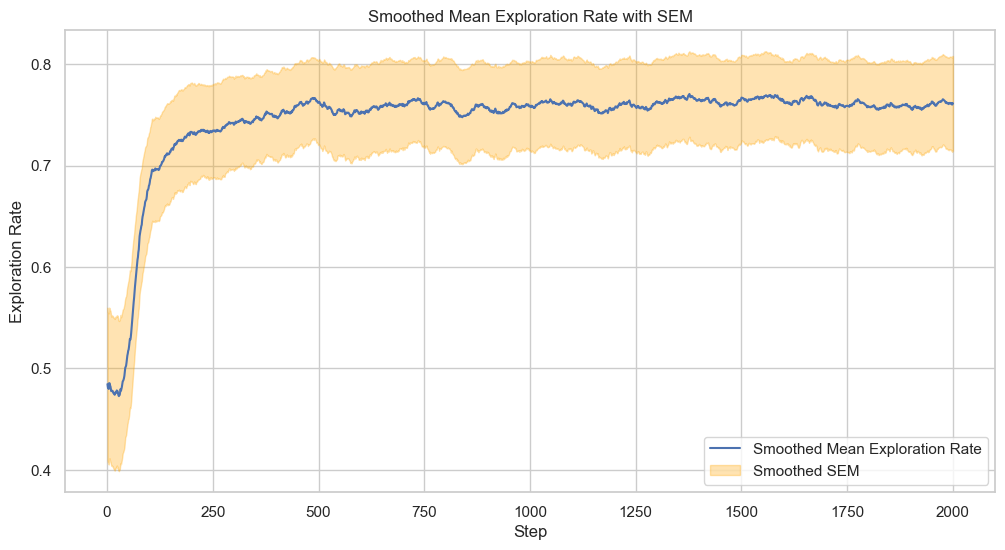

In [8]:
plot_with_sem(df_con_noisy_reward)

In [9]:
def plot_metric_grid(dataset1, dataset2, suptitle=""):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    print(len(dataset1['reward'])/40)
    window = int(len(dataset1['reward'])/40)
    
    for ax, metric_name in zip(axes, ['reward', 'regret', 'exploration_rate']):
        df1 = dataset1.get(metric_name)
        df2 = dataset2.get(metric_name)
        
        data1 = df1.drop(columns='Step')
        mean_vals1 = data1.mean(axis=1)
        sem_vals1 = data1.sem(axis=1)
        data2 = df2.drop(columns='Step')
        mean_vals2 = data2.mean(axis=1)
        sem_vals2 = data2.sem(axis=1)
        steps = df1['Step']
        
        mean_smooth1 = mean_vals1.rolling(window, center=True, min_periods=1).mean()
        sem_smooth1 = sem_vals1.rolling(window, center=True, min_periods=1).mean()
        mean_smooth2 = mean_vals2.rolling(window, center=True, min_periods=1).mean()
        sem_smooth2 = sem_vals2.rolling(window, center=True, min_periods=1).mean()
        
        ax.plot(steps, mean_smooth1, label='NoisyNet-DQN')
        ax.plot(steps, mean_smooth2, label='Regular DQN')
        ax.fill_between(
            steps,
            mean_smooth1 - sem_smooth1,
            mean_smooth1 + sem_smooth1,
            alpha=0.2,
            color='blue',
            label='NoisyNet-DQN SEM'
        )
        ax.fill_between(
            steps,
            mean_smooth2 - sem_smooth2,
            mean_smooth2 + sem_smooth2,
            alpha=0.3,
            color='orange',
            label='regular DQN SEM'
        )
        ax.set_title(metric_name.capitalize())
        ax.set_xlabel('Step')
        ax.set_ylabel(metric_name.capitalize())
        ax.legend()
        
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"results/{suptitle} results.png", dpi=300, bbox_inches='tight')
    plt.show()

50.0


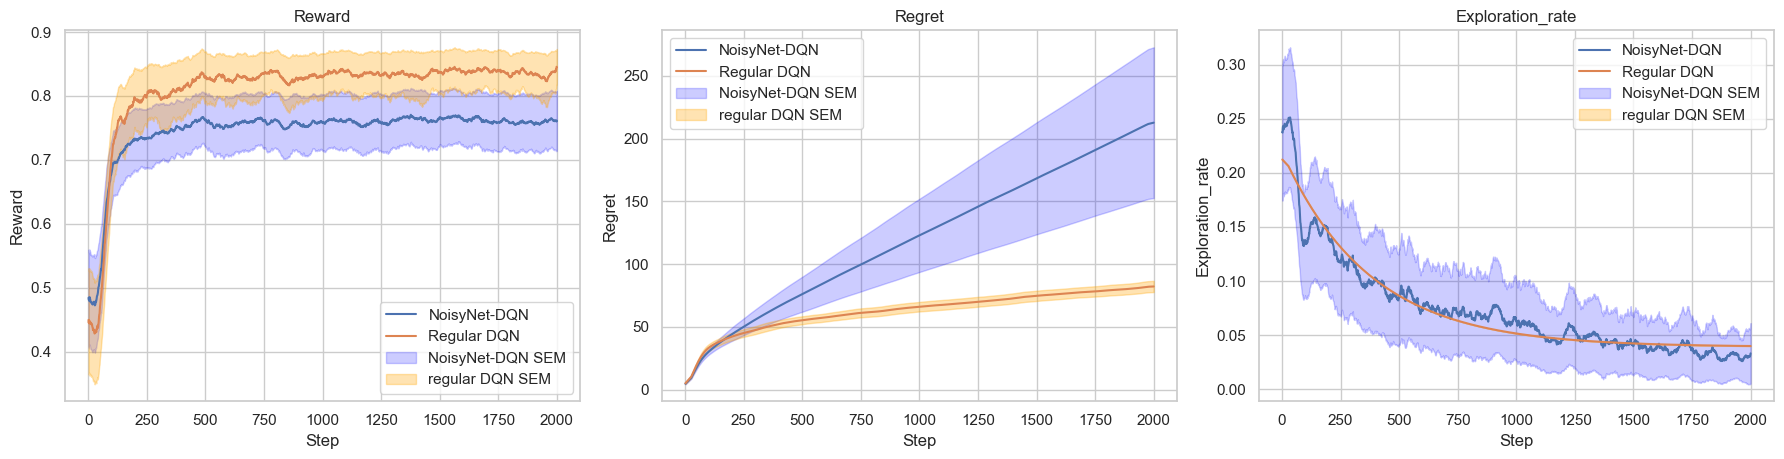

In [10]:
dataset1 = {
    'reward': df_con_noisy_reward,
    'regret': df_con_noisy_regret,
    'exploration_rate': df_con_noisy_expl
}
dataset2 = {
    'reward': df_con_regular_reward,
    'regret': df_con_regular_regret,
    'exploration_rate': df_con_regular_expl
}

plot_metric_grid(dataset1, dataset2, suptitle="ContextualBandit stat")

50.0


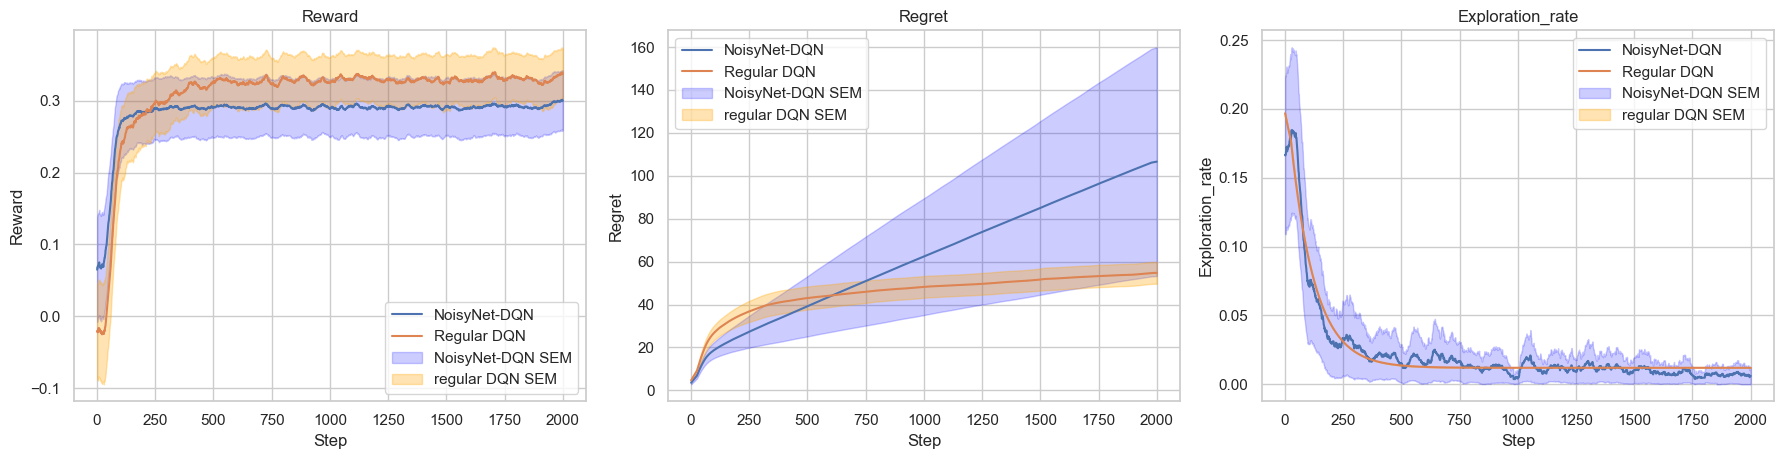

In [11]:
dataset1 = {
    'reward': df_nn_noisy_reward,
    'regret': df_nn_noisy_regret,
    'exploration_rate': df_nn_noisy_expl
}
dataset2 = {
    'reward': df_nn_regular_reward,
    'regret': df_nn_regular_regret,
    'exploration_rate': df_nn_regular_expl
}

plot_metric_grid(dataset1, dataset2, suptitle="NNBandit stat")

In [12]:
def epsilon_decay(t, a, b, c):
    return a * np.exp(-b * t) + c

def fit_epsilon_decay(steps, mean_exploration_rate):
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
    popt, pcov = curve_fit(epsilon_decay, steps, mean_exploration_rate, bounds=([0,0,0],[1,1,1]))
    
    fitted_vals = epsilon_decay(steps, *popt)
    
    plt.figure(figsize=(12, 6))
    plt.plot(steps, mean_exploration_rate)
    plt.plot(steps, fitted_vals)
    print(f'a={popt[0]:.3f}, b={popt[1]:.5f}, c={popt[2]:.3f}')
    plt.show()

a=0.179, b=0.00267, c=0.039


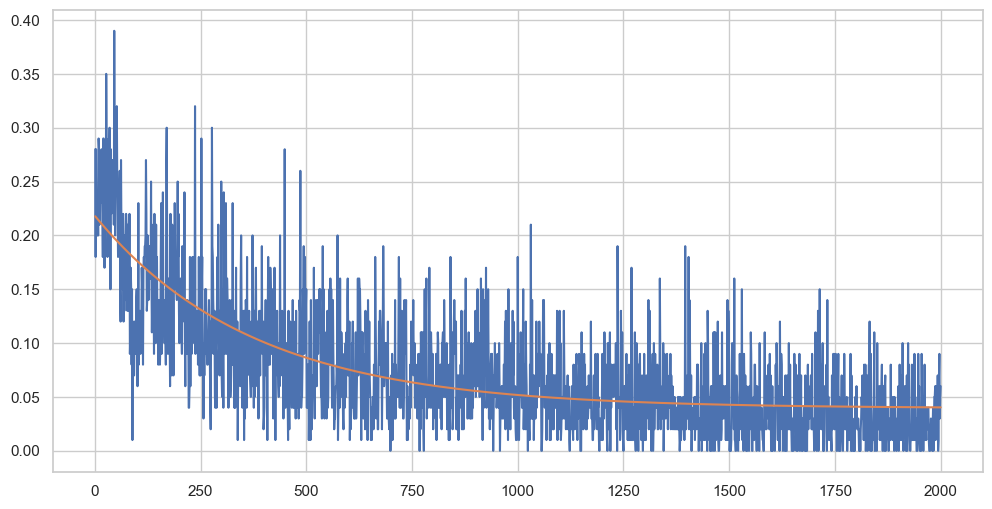

In [13]:
steps = df_con_noisy_expl['Step']
mean_exploration_rate = df_con_noisy_expl.drop(columns='Step').mean(axis=1)
fit_epsilon_decay(steps, mean_exploration_rate)

a=0.207, b=0.00965, c=0.012


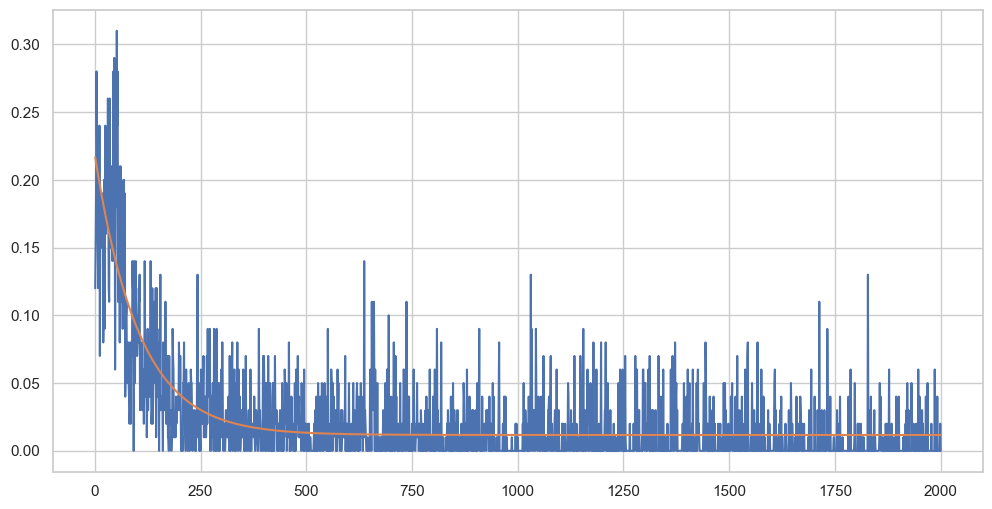

In [14]:
steps = df_nn_noisy_expl['Step']
mean_exploration_rate = df_nn_noisy_expl.drop(columns='Step').mean(axis=1)
fit_epsilon_decay(steps, mean_exploration_rate)

In [15]:
df11 = pd.read_parquet('../artifacts/run-8czromre-history-v1/0000.parquet')
df12 = pd.read_parquet('../artifacts/run-8czromre-history-v1/0001.parquet')
df2 = pd.read_parquet('../artifacts/run-vyn8tc47-history-v0/0000.parquet')
df3 = pd.read_parquet('../artifacts/run-2miwabkf-history-v0/0000.parquet')
df_mnist_noisy_reward_0 = pd.concat([df11[['reward']], df12[['reward']]], ignore_index=True)
df_mnist_noisy_regret_0 = pd.concat([df11[['regret']], df12[['regret']]], ignore_index=True)
df_mnist_noisy_expl_0 = pd.concat([df11[['exploration_rate']], df12[['exploration_rate']]], ignore_index=True)
df_mnist_noisy_reward_1 = df2[['reward']]
df_mnist_noisy_regret_1 = df2[['regret']]
df_mnist_noisy_expl_1 = df2[['exploration_rate']]
df_mnist_noisy_reward_2 = df3[['reward']]
df_mnist_noisy_regret_2 = df3[['regret']]
df_mnist_noisy_expl_2 = df3[['exploration_rate']]

_a = df_mnist_noisy_reward_0.join(df_mnist_noisy_reward_1, lsuffix='_0', rsuffix='_1')
_b = df_mnist_noisy_regret_0.join(df_mnist_noisy_regret_1, lsuffix='_0', rsuffix='_1')
_c = df_mnist_noisy_expl_0.join(df_mnist_noisy_expl_1, lsuffix='_0', rsuffix='_1')
a = df_mnist_noisy_reward_2.join(_a, lsuffix='_0', rsuffix='_1')
b = df_mnist_noisy_regret_2.join(_b, lsuffix='_0', rsuffix='_1')
c = df_mnist_noisy_expl_2.join(_c, lsuffix='_0', rsuffix='_1')
a['Step'] = a.index
b['Step'] = b.index
c['Step'] = c.index


df4 = pd.read_parquet('../artifacts/run-emhk2e0g-history-v0/0000.parquet')
df5 = pd.read_parquet('../artifacts/run-su1agzym-history-v0/0000.parquet')
df6 = pd.read_parquet('../artifacts/run-7jin0xg3-history-v0/0000.parquet')
df_mnist_reg_reward_0 = df4[['reward']]
df_mnist_reg_regret_0 = df4[['regret']]
df_mnist_reg_expl_0 = df4[['exploration_rate']]
df_mnist_reg_reward_1 = df5[['reward']]
df_mnist_reg_regret_1 = df5[['regret']]
df_mnist_reg_expl_1 = df5[['exploration_rate']]
df_mnist_reg_reward_2 = df6[['reward']]
df_mnist_reg_regret_2 = df6[['regret']]
df_mnist_reg_expl_2 = df6[['exploration_rate']]
_x = df_mnist_reg_reward_0.join(df_mnist_reg_reward_1, lsuffix='_0', rsuffix='_1')
_y = df_mnist_reg_regret_0.join(df_mnist_reg_regret_1, lsuffix='_0', rsuffix='_1')
_z = df_mnist_reg_expl_0.join(df_mnist_reg_expl_1, lsuffix='_0', rsuffix='_1')
x = df_mnist_reg_reward_2.join(_x, lsuffix='_0', rsuffix='_1')
y = df_mnist_reg_regret_2.join(_y, lsuffix='_0', rsuffix='_1')
z = df_mnist_reg_expl_2.join(_z, lsuffix='_0', rsuffix='_1')
x['Step'] = x.index
y['Step'] = y.index
z['Step'] = z.index



dataset8 = {
    'reward': a,
    'regret': b,
    'exploration_rate': c
}
dataset9 = {
    'reward': x,
    'regret': y,
    'exploration_rate': z
}

In [25]:
b__ = b.iloc[-1].drop('Step').mean()
y__ = y.iloc[-1].drop('Step').mean()
print(b__)
print(y__)
print(((y__/b__)-1)*100)

254112.66666666666
274512.6666666667
8.027935115395014


7500.0


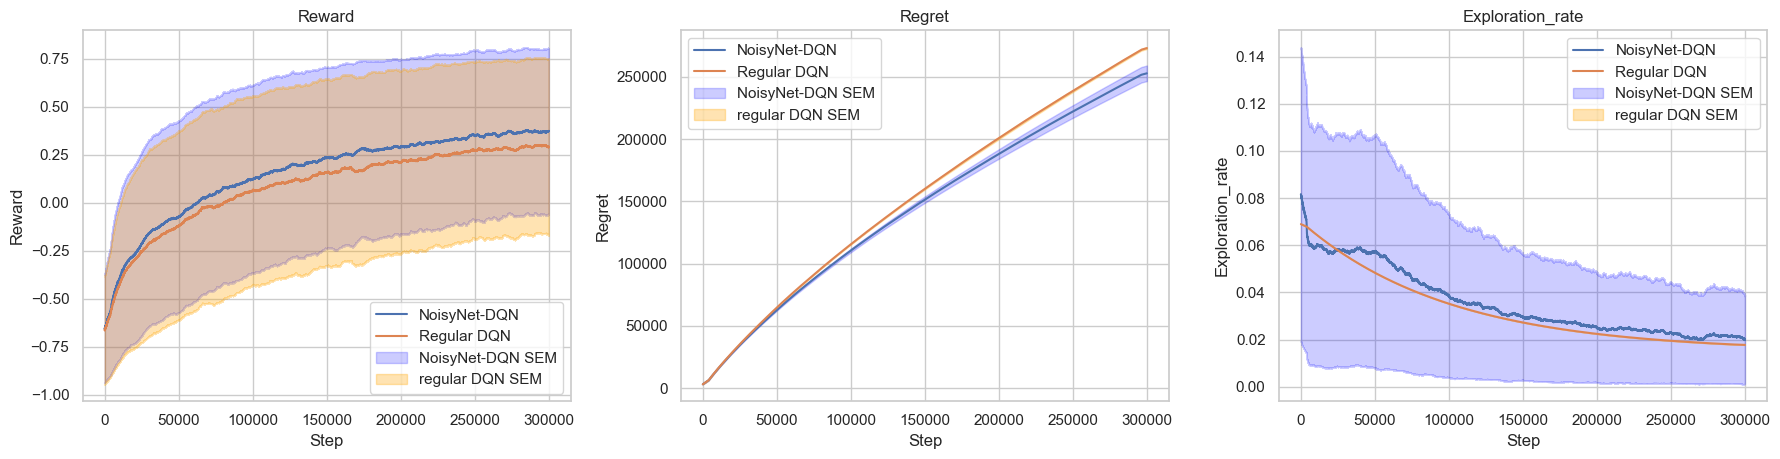

In [18]:
plot_metric_grid(dataset8, dataset9, suptitle="MNISTBandit stat")

In [1]:
df_sampled = c.iloc[::1].reset_index(drop=True)
df_sampled.info()
# plt.plot(df_sampled.drop(columns='Step').mean(axis=1))
# sns.lineplot(data=df_sampled, x='Step', y='exploration_rate_1')
steps = df_sampled['Step']
df_sampled = df_sampled.drop(columns='Step').mean(axis=1)
fit_epsilon_decay(steps, df_sampled)

NameError: name 'c' is not defined